# <u>Chapter 2</u> - Detecting Spam Emails

A `spam detector` is software that runs on the mail server or our local computer and checks the inbox to detect possible spam. As with traditional letterboxes, an inbox is a destination for electronic mail messages. Generally, any spam detector has unhindered access to this repository and can perform tens, hundreds, or even thousands of checks per day to decide whether an incoming email is spam or not. Fortunately, spam detection is a ubiquitous technology that filters out irrelevant and possibly dangerous electronic correspondence.

In this exercise, we implement a spam detector from scratch and present various techniques related to natural language processing.

We will be using a subset of the annotated email corpus found here: <https://spamassassin.apache.org/old/publiccorpus/>

For Windows users download and install "Microsoft C++ Build Tools" from: https://visualstudio.microsoft.com/visual-cpp-build-tools/

In [1]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'matplotlib', 'wordcloud', 'scikit-learn', 'nltk'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

Now, download the datasets.

In [2]:
import os

# Check if the data directory already exists.
if not os.path.exists("data"):
    # URL of the zip data file to download.
    url = "https://github.com/PacktPublishing/Machine-Learning-Techniques-for-Text/raw/main/chapter-02/data.zip"

    # If it doesn't exist, download the zip file.
    !wget {url}

    # Unzip the file into the "data" folder.
    !unzip -q "data.zip"

## Word clouds

For creating the spam detector, we can examine the message’s body and check whether certain words appear more often? Intuitively, those words can serve as a way to separate the two types of emails. An easy way to perform this task is to visualize the body of the message using `word clouds` (also known as `tag clouds`). With this visualization technique, recurring words in the dataset (excluding  articles, pronouns, and a few other cases) appear larger than infrequent ones.

One possible implementation of word clouds in Python is the [word_cloud module](https://github.com/amueller/word_cloud).

(-0.5, 399.5, 199.5, -0.5)

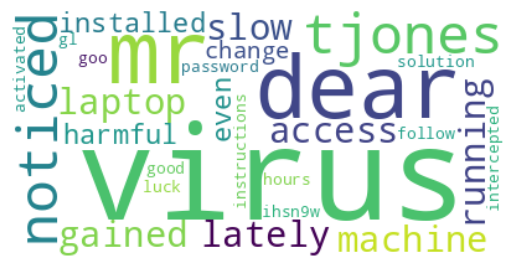

In [3]:
%matplotlib inline
# Import the necessary modules.
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Read the text from the file spam.txt.
text = open('./data/spam.txt').read()

# Create and configure the word cloud object.
wc = WordCloud(background_color="white", max_words=2000)

# Generate the word cloud image from the text.
wordcloud = wc.generate(text.lower())

# Display the generated image.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

The image suggests that the most common word in our spam message is *“virus”* (all words are lowercase).

Notice that techniques such as word clouds are commonplace in ML problems to explore text data before resorting to any solution. We call this process `Exploratory Data Analysis` (EDA). EDA provides an understanding of where to direct our subsequent analysis and visualization methods are the primary tool for this task.

## Label encoding

Next, we learn about the standard approaches for representing words in a piece of text data. In ML problems, there are various ways to represent words; `label encoding` is the simplest form. For example, consider this quote from Aristotle: *"a friend to all is a friend to none"*. Using the label-encoding scheme and a dictionary with words to indices. E.g., the word *"friend"* maps to number *2*. 

In [4]:
from sklearn.preprocessing import LabelEncoder

# Create the label encoder and fit it with data.
labelencoder = LabelEncoder()
labelencoder.fit(["a", "all", "friend", "is", "none", "to"])

# Transform an input sentence.
x = labelencoder.transform(["a", "friend", "to", "all", "is", "a", "friend", "to", "none"])
print(x)

[0 2 5 1 3 0 2 5 4]


## One-hot encoding

Another well-known word representation technique is `one-hot encoding`, which codifies every word as a vector with zeros and a single one. Notice that the position of the one uniquely identifies a specific word; consequently, no two words exist with the same one-hot vector.

In [5]:
from sklearn.preprocessing import OneHotEncoder

# The input.
X = [['a'], ['friend'], ['to'], ['all'], ['is'], ['a'], ['friend'], ['to'], ['none']]

# Create the one-hot encoder.
onehotencoder = OneHotEncoder()

# Fit and transform.
enc = onehotencoder.fit_transform(X).toarray()  
print(enc.T)

[[1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0.]]


## Token count encoding

`Token count encoding`, also known as the `Bag-of-Words` (BoW) representation, counts the absolute frequency of each word within a sentence or a document. The input is represented as a bag of words without taking into account grammar or word order. This method uses a `Term Document Matrix` (TDM) matrix that describes the frequency of each term in the text. Notice that the corresponding cell in the table contains the value *"0"* when no such word is present in the quote.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# The input.
X = ["a friend to all is a friend to none"]

# Create the count vectorizer.
vectorizer = CountVectorizer(token_pattern='[a-zA-Z]+')

# Fit and transform.
x = vectorizer.fit_transform(X)
print(vectorizer.vocabulary_)

{'a': 0, 'friend': 2, 'to': 5, 'all': 1, 'is': 3, 'none': 4}


In [7]:
print(x.toarray()[0])

[2 1 2 1 1 2]


Now use `bigrams` to do the same task.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# The input.
X = ["a friend to all is a friend to none"]

# Create the count vectorizer using bi-grams.
vectorizer = CountVectorizer(ngram_range=(2,2), token_pattern='[a-zA-Z]+')

# Fit and transform.
x = vectorizer.fit_transform(X)
print(vectorizer.vocabulary_)

{'a friend': 0, 'friend to': 2, 'to all': 4, 'all is': 1, 'is a': 3, 'to none': 5}


In [9]:
print(x.toarray()[0])

[2 1 2 1 1 1]


## Tf-idf encoding

One limitation of BoW representations is that they do not consider the value of words inside the corpus. For example, if solely frequency were of prime importance, articles such as *"a"* or *"the"* would provide the most information for a document. Therefore, we need a representation that *penalizes* these frequent words. The remedy is the term `frequency-inverse document frequency` (tf-idf) encoding scheme that allows us to weigh each word in the text. You can consider tf-idf as a heuristic where more common words tend to be less relevant for most semantic classification tasks, and the weighting reflects this approach.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a dummy corpus.
corpus = ['We need to meet tomorrow at the cafeteria.',
        'Meet me tomorrow at the cafeteria.',
        'You have inherited millions of dollars.',
        'Millions of dollars just for you.']

# Create the tf-idf vectorizer.
vectorizer = TfidfVectorizer()

# Generate the tf-idf matrix.
tfidf = vectorizer.fit_transform(corpus)

# Print the result as an array.
print(tfidf.toarray())

[[0.31901032 0.31901032 0.         0.         0.         0.
  0.         0.         0.31901032 0.         0.40462414 0.
  0.31901032 0.40462414 0.31901032 0.40462414 0.        ]
 [0.3889911  0.3889911  0.         0.         0.         0.
  0.         0.49338588 0.3889911  0.         0.         0.
  0.3889911  0.         0.3889911  0.         0.        ]
 [0.         0.         0.37222485 0.         0.47212003 0.47212003
  0.         0.         0.         0.37222485 0.         0.37222485
  0.         0.         0.         0.         0.37222485]
 [0.         0.         0.37222485 0.47212003 0.         0.
  0.47212003 0.         0.         0.37222485 0.         0.37222485
  0.         0.         0.         0.         0.37222485]]


In the following code, we calculate the `cosine similarity` of the tf-idf vectors between the corpus’s first and second examples.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert the matrix to an array.
tfidf_array = tfidf.toarray()

# Calculate the cosine similarity between the first amd second example.
print(cosine_similarity([tfidf_array[0]], [tfidf_array[1]]))

[[0.62046087]]


As expected, the value between the first and second examples is high and equal to *0.62*. 

In [12]:
# Calculate the cosine similarity among all examples.
print(cosine_similarity(tfidf_array))

[[1.         0.62046087 0.         0.        ]
 [0.62046087 1.         0.         0.        ]
 [0.         0.         1.         0.55420536]
 [0.         0.         0.55420536 1.        ]]



We also repeat the same calculation between all tf-idf vectors. Between the first and the third example, it is *0*, *0.55* between the third and the fourth, and so on.

## Tokenization

`Tokenization` is a general process where we split textual data into smaller components called tokens. These can be words, phrases, symbols, or other meaningful elements. 

In [13]:
# Import the toolkit.
import nltk
nltk.download('punkt')

# Tokenize the input text.
wordTokens = nltk.word_tokenize("a friend to all is a friend to none")

print(wordTokens)

['a', 'friend', 'to', 'all', 'is', 'a', 'friend', 'to', 'none']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


As words are the tokens of a sentence, sentences are the tokens of a paragraph.

In [14]:
# Tokenize the input paragraph.
sentenceTokens = nltk.sent_tokenize("A friend to all is a friend to none. \
                                    A friend to none is a friend to all. \
                                    A friend is a friend.")

print(sentenceTokens)

['A friend to all is a friend to none.', 'A friend to none is a friend to all.', 'A friend is a friend.']


We can even create our tokenizer by incorporating different search patterns called `regular expressions` (regexp). The code for tokenizing email addresses is shown below.

In [15]:
# Create the Regexp tokenizer.
tokenizer = nltk.tokenize.RegexpTokenizer(pattern='^([a-z0-9_\.-]+)@([a-z0-9_\.-]+)\.([a-z\.]{2,6})$')

# Tokenize a valid email address.
tokens = tokenizer.tokenize("john@doe.com")

print(tokens)

[('john', 'doe', 'com')]


The output tokens for the invalid email are as follows.

In [16]:
# Tokenize a non-valid email address.
tokens = tokenizer.tokenize("john-AT-doe.com")

print(tokens)

[]


## Stop words removal

A typical task during the preprocessing phase is removing all the words that presumably help us focus on the most important information in the text. These are called `stop words` and there is no universal list in English or any other language.

(-0.5, 399.5, 199.5, -0.5)

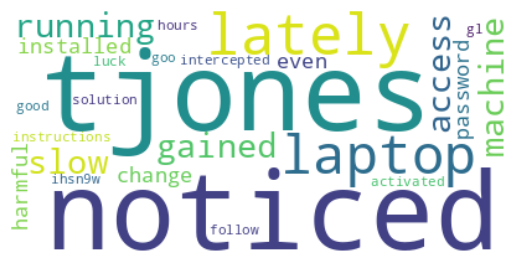

In [17]:
from wordcloud import WordCloud, STOPWORDS

# Read the text from the file data.txt.
text = open('./data/spam.txt').read()

# Get all stopwords and update with few others.
sw = set(STOPWORDS) 
sw.update(["dear", "virus", "mr"])

# Create and configure the word cloud object.
wc = WordCloud(background_color="white", stopwords=sw, max_words=2000)

# Generate the word cloud image from the text.
wordcloud = wc.generate(text.lower())

# Display the generated image.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Stemming

`Stemming` maps a word to its root form and is the process of cutting off the end (suffix) or the beginning (prefix) of an inflected word and ending up with its stem (the root word).

In [18]:
# Import the Porter stemmer.
from nltk.stem import PorterStemmer

# Create the stemmer.
stemmer = PorterStemmer()

# Stem the words 'playing', 'plays', 'played'.
stemmer.stem('playing')

'play'

In [19]:
stemmer.stem('plays')

'play'

In [20]:
stemmer.stem('played')

'play'

Notice that the output of stemming doesn’t need to be a valid word.

In [21]:
# Stem the word 'bravery'
stemmer.stem('bravery')

'braveri'

We can even create our stemmer using regular expressions.

In [22]:
from nltk.stem import RegexpStemmer

# Create the stemmer matching words ending with 'ed'.
stemmer = RegexpStemmer('ed')

# Stem the verbs 'playing', 'plays', 'played'.
stemmer.stem('playing')

'playing'

In [23]:
stemmer.stem('plays')

'plays'

In [24]:
stemmer.stem('played')

'play'

## Lemmatization

`Lemmatization` is another sophisticated approach for reducing the inflectional forms of a word to a base root. The method performs morphological analysis of the word and obtains its proper lemma (the base form under which it appears in a dictionary).

In [25]:
# Import the WordNet Lemmatizer.
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# Create the lemmatizer.
lemmatizer = WordNetLemmatizer()

# Lemmatize the verb 'played'.
lemmatizer.lemmatize('played', pos='v')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'play'

In [26]:
# Lemmatize the verb 'led'.
lemmatizer.lemmatize('led', pos='v')

'lead'

In [27]:
# Lemmatize the adjective 'better'.
lemmatizer.lemmatize('better', pos='a')

'good'

## Classification

The [SpamAssassin public mail corpus](https://spamassassin.apache.org/old/publiccorpus/) is a selection of email messages suitable for developing spam filtering systems. It 
offers two variants for the messages, either in plain text or HTML formatting. For simplicity, we will use only the first type in this exercise. The term coined to describe the opposite of spam emails is ham since the two words are related to meat products (spam refers to canned ham). In this exercise, we use a subset of the corpus. 


Initially, we read the messages for the two categories (ham and spam) and split them into training and testing groups. As a rule of thumb, we can choose a *75:25* split between the two sets, attributing a more significant proportion to the training data.

In [27]:
import email
import glob
import numpy as np
from operator import is_not
from functools import partial
from sklearn.model_selection import train_test_split

# Load the path for each email file for both categories.
ham_files = train_test_split(glob.glob('./data/20030228_hard_ham/hard_ham/*'), random_state=123)
spam_files = train_test_split(glob.glob('./data/20050311_spam_2/spam_2/*'), random_state=123)

# Method for getting the content of an email.
def get_content(filepath):
    file = open(filepath, encoding='latin1')
    message = email.message_from_file(file)
    
    for msg_part in message.walk():
        # Keep only messages with text/plain content.
        if msg_part.get_content_type() == 'text/plain':
            return msg_part.get_payload()

# Get the training and testing data.
ham_train_data = [get_content(i) for i in ham_files[0]]
ham_test_data = [get_content(i) for i in ham_files[1]]
spam_train_data = [get_content(i) for i in spam_files[0]]
spam_test_data = [get_content(i) for i in spam_files[1]]

# Keep emails with non-empty content.
ham_train_data = list(filter(None, ham_train_data))
ham_test_data = list(filter(None, ham_test_data))
spam_train_data = list(filter(None, spam_train_data))
spam_test_data = list(filter(None, spam_test_data))

# Merge the train/test files for both categories.
train_data = np.concatenate((ham_train_data, spam_train_data))
test_data = np.concatenate((ham_test_data, spam_test_data))

# Assign a class for each email (ham = 0, spam = 1).
ham_train_class = [0]*len(ham_train_data)
ham_test_class = [0]*len(ham_test_data)
spam_train_class = [1]*len(spam_train_data)
spam_test_class = [1]*len(spam_test_data)

# Merge the train/test classes for both categories.
train_class = np.concatenate((ham_train_class, spam_train_class))
test_class = np.concatenate((ham_test_class, spam_test_class))

The next step is to preprocess the data using the techniques we learned. In the code that follows, we remove all stop words. 

In [28]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Tokenize the train/test data.
train_data = [word_tokenize(i) for i in train_data]
test_data = [word_tokenize(i) for i in test_data]


# Method for removing the stop words.
def remove_stop_words(input):
    result = [i for i in input if i not in ENGLISH_STOP_WORDS]
    return result

# Remove the stop words.
train_data = [remove_stop_words(i) for i in train_data]
test_data = [remove_stop_words(i) for i in test_data]

Now we lemmatize the words.

In [29]:
# Create the lemmatizer.
lemmatizer = WordNetLemmatizer()

# Method for lemmatizing the text.
def lemmatize_text(input):
    return [lemmatizer.lemmatize(i) for i in input]

# Lemmatize the text.
train_data = [lemmatize_text(i) for i in train_data]
test_data = [lemmatize_text(i) for i in test_data]

# Reconstruct the data.
train_data = [" ".join(i) for i in train_data]
test_data = [" ".join(i) for i in test_data]

We continue with the extraction of the features of each sentence in the two sets. This step uses tf-idf vectorization after training the vectorizer on the training data. 

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer.
vectorizer = TfidfVectorizer()

# Fit with the train data.
vectorizer.fit(train_data)

# Transform the test/train data into features.
train_data_features = vectorizer.transform(train_data)
test_data_features = vectorizer.transform(test_data)

Each of the *670* emails in the training set is represented by a feature vector with a size of *28337*. 

In [31]:
print(train_data_features.shape)

(670, 28337)


## Support Vector Machines

One of the most well-known supervised learning algorithms is the `Support Vector Machines` (SVM) algorithm.

We evaluate its performance in both the test and training sets. We are primarily interested in the first result, as it quantifies the accuracy of our model on unseen data; essentially, how well it generalizes. On the other hand, the performance on the training set indicates how well our model learned from the training data. As you can observe, the accuracy, in the latter case, is not *100%* as one might expect. In practical problems, it is almost always much less than *99%*. 

In [32]:
from sklearn import svm

# Create the classifier.
svm_classifier = svm.SVC(kernel="rbf", C=1.0, gamma=1.0, probability=True)

# Fit the classifier with the train data.
svm_classifier.fit(train_data_features.toarray(), train_class)

# Get the classification score of the train data.
svm_classifier.score(train_data_features.toarray(), train_class)

0.9970149253731343

Now, use the test set.

In [33]:
# Get the classification score of the test data.
svm_classifier.score(test_data_features.toarray(), test_class)

0.8755760368663594

## Naïve Bayes

`Naïve Bayes` is a classification algorithm based on the `Bayes Theorem`. 

As with the SVM, it is straightforward to incorporate Naïve Bayes.

In [34]:
from sklearn import naive_bayes

# Create the classifier.
nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

# Fit the classifier with the train data.
nb_classifier.fit(train_data_features.toarray(), train_class)

# Get the classification score of the train data.
nb_classifier.score(train_data_features.toarray(), train_class)

0.8641791044776119

Next, we incorporate the test set.

In [35]:
# Get the classification score of the test data.
nb_classifier.score(test_data_features.toarray(), test_class)

0.8571428571428571

The outcome suggests that the performance of this classifier is inferior. Also, notice the result on the actual training set, which is low and very close to the performance on the test set.

## Accuracy

The standard approach for any ML problem incorporates different classification algorithms and examines which works best. Previously, we used two classification methods for the spam filtering problem, but our job is not done yet; we need to evaluate their performance in more detail.

`Accuracy` is the percentage of correctly classified examples by an algorithm divided by the total number of examples. The code below calculates accuracy on the same data; its value is identical to the one in the previous section.

In [36]:
from sklearn import metrics
 
# Get the predicted classes.
test_class_pred = nb_classifier.predict(test_data_features.toarray())

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_class, test_class_pred)

0.8571428571428571

## Precision and Recall

`Precision` precision tells us the proportion of positive identifications that are, in reality, correct, and `Recall` tells us the proportion of the actual positives that are identified correctly.

In [37]:
# Calculate the precision on the test set.
metrics.precision_score(test_class, test_class_pred)

0.8564814814814815

In [38]:
# Calculate the recall on the test set.
metrics.recall_score(test_class, test_class_pred)

1.0

## F-score

`F-score`, is the harmonic mean of precision and recall. When precision and recall reach their perfect score (equal to *1*), F-score becomes *1*.

In [39]:
# Calculate the F-score on the test set.
metrics.f1_score(test_class, test_class_pred)

0.9226932668329177

## ROC and AUC

When the classifier returns some kind of confidence score for each prediction, we can use another technique for evaluating performance called the `Receiver Operator Characteristic` (ROC) curve. A ROC curve is a graphical plot that shows the model’s performance at all classification thresholds. The grayed area in these plots, called 
the `Area Under the ROC Curve` (AUC), is related to the quality of our model; the higher its surface, the better it is.

Next, we calculate the ROC curves for both classifiers.

Text(0.5, 0.98, 'ROC curve comparison')

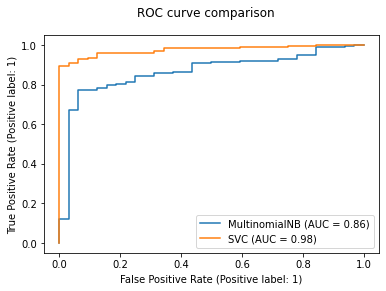

In [40]:
# Create a single figure and axis for the ROC plot
fig, ax = plt.subplots()

# Obtain the scores for each prediction.
probs = nb_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Compute Area Under the Curve.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MultinomialNB').plot(ax=ax)

# Obtain the scores for each prediction.
probs = svm_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Compute Area Under the Curve.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
svm_disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='SVC').plot(ax=ax)

svm_disp.figure_.suptitle("ROC curve comparison")

According to the figure, the AUC is *0.98* for SVM and *0.87* for Naïve Bayes. All results so far corroborate our initial assumption of the superiority of the SVM model.

Finally, we calculate the ROC along with the `Precision-Recall curve` for the Naïve Bayes model.

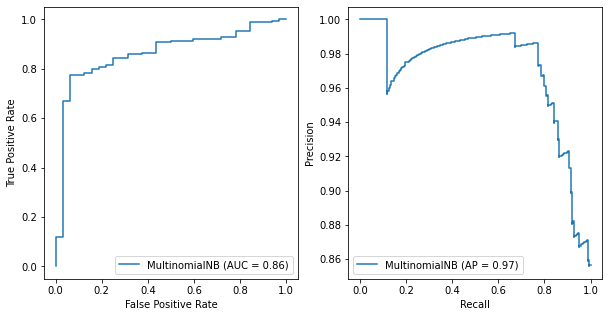

In [41]:
# Obtain the scores for each prediction.
probs = nb_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Compute the Receiver Operating Characteristic.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Compute Area Under the Curve.
roc_auc = metrics.auc(fpr, tpr)

# Create the ROC curve.
rc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MultinomialNB')

# Create the precision recall curves.
precision, recall, thresholds = metrics.precision_recall_curve(test_class, test_score)
ap = metrics.average_precision_score(test_class, test_score)
pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name='MultinomialNB')

# Plot the curves.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
rc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)

Both plots summarize the trade-offs between the rates on the x and y axes using different probability thresholds. In the right plot, the average precision (AP) is *0.97* for the Naïve Bayes model.

## What we have learned …

| | | |
| --- | --- | --- |
| **Visualizations**<ul><li>Word clouds</li></ul> | **Text representations**<ul><li>Label encoding</li><li>One-hot encoding</li><li>Token count encoding</li><li>Tf-idf encoding</li></ul> | **ML algorithms & models**<ul><li>Support Vector Machines</li><li>Naïve Bayes</li></ul> |
| **Text preprocessing**<ul><li>Tokenization</li><li>Stop words removal</li><li>Stemming</li><li>Lemmatization</li><li>Regular expressions</li></ul> | **ML concepts**<ul><li>Supervised learning</li><li>Creating train and test sets</li><li>Feature engineering</li><li>Overfitting</li></ul> | **Performance metrics**<ul><li>Accuracy</li><li>Precision</li><li>Recall</li><li>F-score</li><li>ROC and AUC</li><li>True Positive Rate</li></ul> |
| | | |

## Author Information

- **Author:** Nikos Tsourakis
- **Email:** nikos@tsourakis.net
- **Website:** [tsourakis.net](https://tsourakis.net)
- **Date:** November 20, 2023